# Práctica 1 Hardware Cuántico
**Autor: Jorge Vázquez Pérez**

In [1]:
#%pip install qiskit
#%pip install graphviz

import numpy as np
from qiskit import QuantumCircuit, transpile, execute
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution, array_to_latex
from qiskit.quantum_info import Statevector

from qiskit_ibm_provider import IBMProvider
import qiskit.tools.jupyter

IBMProvider.save_account('368ce8e3d58876f8744c71270f2727fd9883b04d75ad646fa5f7345d0b9dede6f06cdc12ebf7e0d0db8a2f0881369da230f432512437401e11ae29dd202b9561', overwrite=True)

%qiskit_version_table

Primero de todo, creamos el circuito de Bell, generando el estado deseado.

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


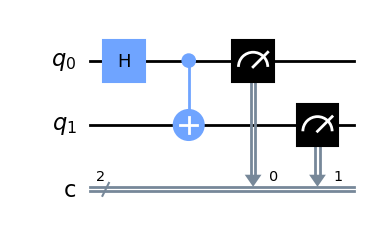

In [2]:
# Create the bell state circuit
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

qc.draw("mpl")

Para comprobar que, efectivamente, el estado generado se corresponde con el que nosotros buscamos, vamos a representar el vector de estado del circuito.

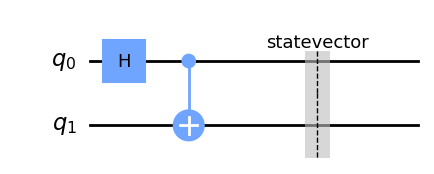

<IPython.core.display.Latex object>

In [3]:
qc_copy = qc.copy()
qc_copy.remove_final_measurements()
qc_copy.save_statevector()

display(qc_copy.draw("mpl"))

backend = Aer.get_backend("aer_simulator_statevector")
tqc = transpile(qc_copy, backend)
statevector = backend.run(tqc).result().get_statevector(tqc)

display(Statevector(statevector).draw('latex', prefix=f"|q_1 q_0 \\rangle = {array_to_latex(statevector, source=True)} = "))

Una vez realizadas las correspondientes comprobaciones, es hora de ejecutar el circuito en los diferentes backends. Utilizaremos los siguientes:

1. El simulador cuántico de IBM Quantum `simulator_statevector`.
2. El computador cuántico real de IBM Quantum menos ocupado, para reducir los tiempos de espera en las colas.
3. El `aer_simulator`, de Aer, con el método de simulación automático y con el modelo de ruido del ordenador cuántico real seleccionado anteriormente. 

In [4]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import least_busy

provider = IBMProvider()
shots = 1000


# Define the backends
simulator_backend = provider.get_backend("simulator_statevector")

devices = provider.backends(simulator=False, operational=True)
real_backend = least_busy(devices)
noise_model_real = NoiseModel.from_backend(real_backend)
bases_gates_real = real_backend.basis_gates
coupling_map_real = real_backend.coupling_map

noise_simulator_backend = Aer.get_backend("aer_simulator")


# Execute the circuit on the different backends
simulator_job = execute(qc, simulator_backend, shots=shots)

real_job = execute(qc, real_backend, shots=shots)
real_job_id = real_job.job_id()

noise_simulator_job = execute(qc, noise_simulator_backend, noise_model=noise_model_real,basis_gates=bases_gates_real,coupling_map=coupling_map_real, shots=shots)

Ahora, una vez termine la ejecución en el computador cuántico real, recuperamos los resultados y vemos las diferentes salidas.

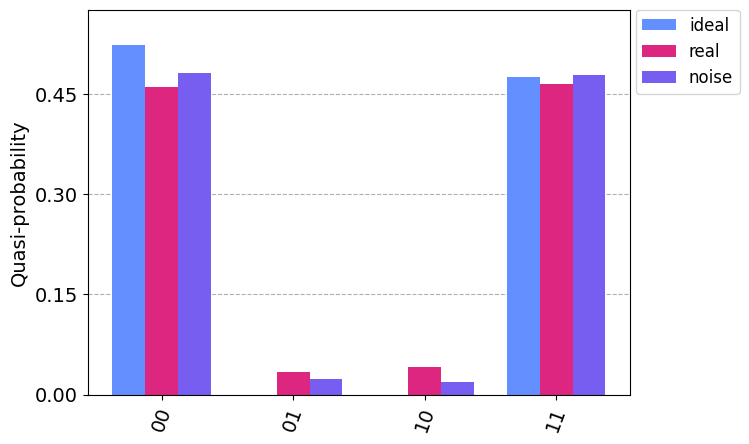

In [5]:
real_job = provider.retrieve_job(real_job_id)

# Get the results
simulator_counts = simulator_job.result().get_counts()
real_counts = real_job.result().get_counts()
noise_simulator_counts = noise_simulator_job.result().get_counts()

plot_distribution([simulator_counts, real_counts, noise_simulator_counts],legend=['ideal', 'real', 'noise'], bar_labels=False)

Podemos observar en el anterior gráfico, resultados totalmente esperados en cada uno de los casos. Evidentemente, en el caso ideal vemos como en ningún caso puede haber resultados $|01\rangle$ y $|10\rangle$, puesto que no se encuentran como opción en el vector de estado o, dicho de otra manera, la probabilidad de medirlos se mantiene en 0 por la ausencia de ruido. Sin embargo en el caso real y en el caso simulado con el modelo de ruido del ordenador real vemos como los resultados son muy similares y como el ruido existente, en un caso natural y en otro simulado, provoca que haya una probabilidad residual de medir $|01\rangle$ y $|10\rangle$.

Ahora, antes de calcular la tasa de error de la puerta CX, veamos la topología del ordenador real empleado en este caso.

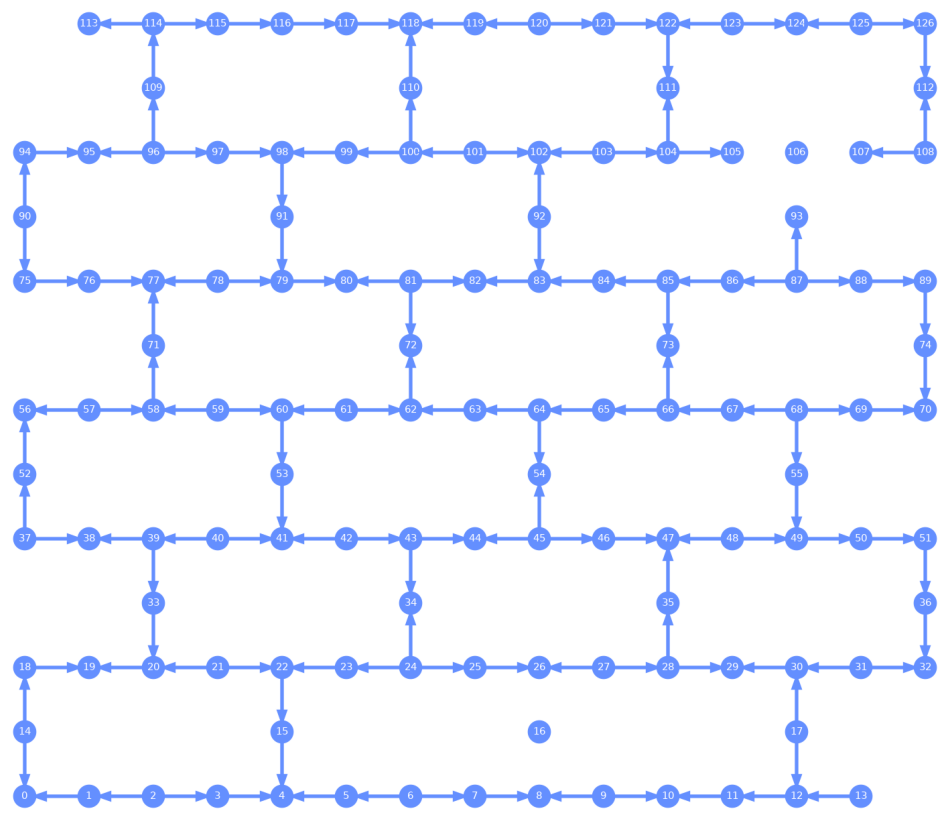

In [6]:
from qiskit.visualization import plot_gate_map

plot_gate_map(real_backend, figsize=(12, 12), font_size=11, plot_directed=True)

Ahora, calculemos la tasa de error. Como ningún ordenador cuántico de IBM Quantum soporta la puerta CX de forma nativa, mediremos la tasa de error de la puerta ECR, que es soportada por todos y, según la documentción de IBM es "*equivalente a una CX excepto pre-rotaciones de un solo qubit*".

In [7]:
cx_error_rates = {}
for pairs in coupling_map_real:
    cx_error_rates[pairs] = real_backend.properties().gate_error('ecr', pairs)

min_error_rate_key = min(cx_error_rates, key=cx_error_rates.get)
min_error_rate_value = cx_error_rates[min_error_rate_key]

max_error_rate_key = max(cx_error_rates, key=cx_error_rates.get)
max_error_rate_value = cx_error_rates[max_error_rate_key]

print(f"Minimum qubits {min_error_rate_key} have the minimum error rate: {min_error_rate_value}")
print(f"Maximum qubits {max_error_rate_key} have the maximum error rate: {max_error_rate_value}")

Minimum qubits (91, 79) have the minimum error rate: 0.0027755559375400585
Maximum qubits (33, 20) have the maximum error rate: 1


Ahora, veamos dónde se sitúan físicamente estos pares en la topología observada anteriormente. En <span style="color:#f46932">naranja</span> podemos observar el par con la tasa de error más pequeña y en <span style="color:#00b074">verde</span> el par con la tasa de error más grande.

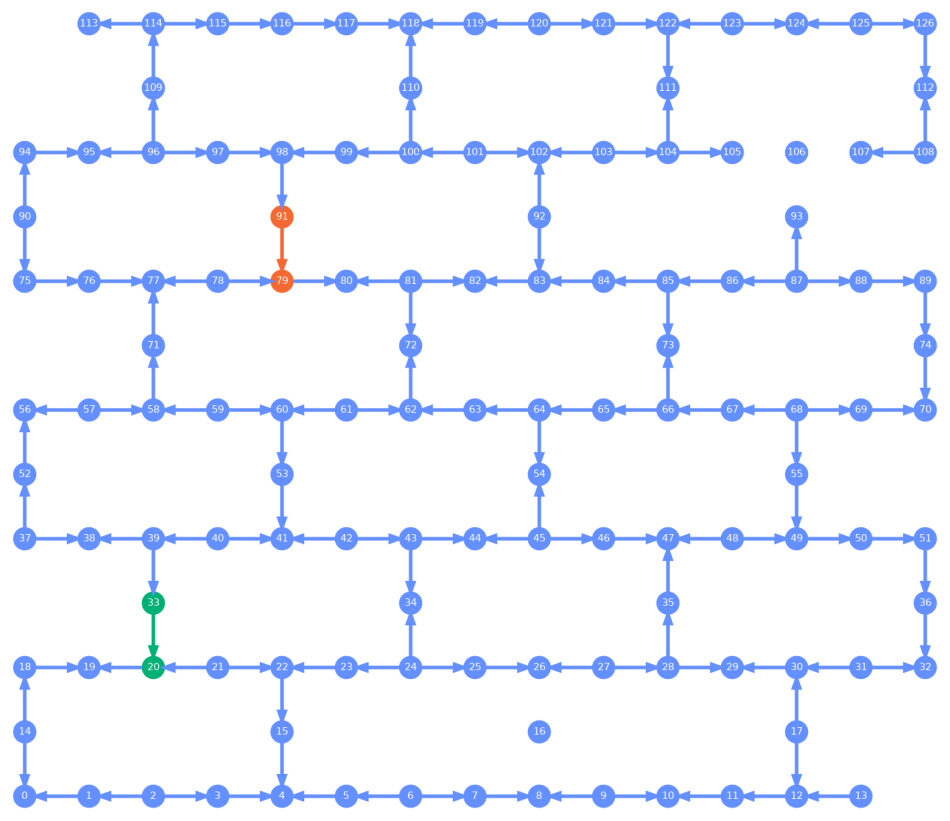

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the gate map with highlighted max and min pairs
min_index = list(coupling_map_real).index(min_error_rate_key)
max_index = list(coupling_map_real).index(max_error_rate_key)

edge_color = ["#648fff"] * len(list(coupling_map_real))
qubit_color = ["#648fff"] * real_backend.configuration().n_qubits

edge_color[min_index] = "#f46932"
edge_color[max_index] = "#00b074"

qubit_color[min_error_rate_key[0]] = "#f46932"
qubit_color[min_error_rate_key[1]] = "#f46932"
qubit_color[max_error_rate_key[0]] = "#00b074"
qubit_color[max_error_rate_key[1]] = "#00b074"

plot_gate_map(real_backend, figsize=(12, 12), font_size=11, plot_directed=True, qubit_color=qubit_color, line_color=edge_color)


Ahora, para visualizar realmente como estas diferentes tasas de error afectan a la ejecución, transpilemos nuestro circuito a cada uno de estos pares y ejecutémoslos en el ordenador cuántico real para visualizar los resultados.

In [9]:
# Best version
tqc_best = transpile(qc, real_backend, initial_layout=[min_error_rate_key[0], min_error_rate_key[1]])
best_job = execute(tqc_best, real_backend, shots=shots)
best_job_id = best_job.job_id()

# Worst version
tqc_worst = transpile(qc, real_backend, initial_layout=[max_error_rate_key[0], max_error_rate_key[1]])
worst_job = execute(tqc_worst, real_backend, shots=shots)
worst_job_id = worst_job.job_id()

Ahora, una vez se ha ejecutado recuperamos los resultados y los represetamos.

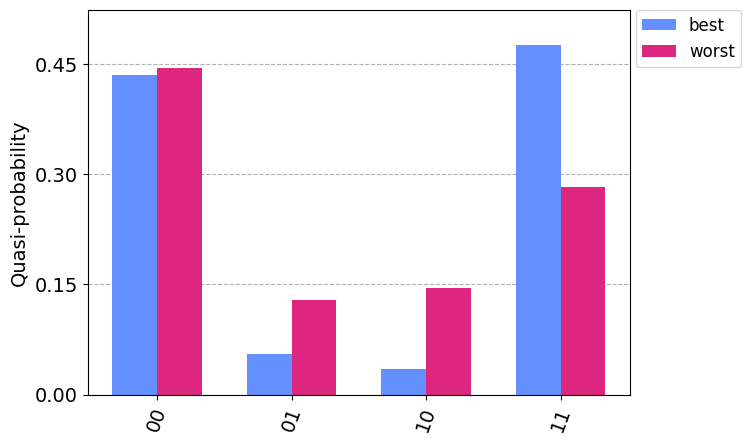

In [10]:
best_job = provider.retrieve_job(best_job_id)
worst_job = provider.retrieve_job(worst_job_id)

# Get the results
best_counts = best_job.result().get_counts()
worst_counts = worst_job.result().get_counts()

plot_distribution([best_counts, worst_counts],legend=['best', 'worst'], bar_labels=False)

Como era de esperar, el circuíto transpilado al par con menos error devuelve mucho mejor resultado, siendo el número de medidas en los valores $|01\rangle$ y $|10\rangle$ mucho menores que para el circuito transpilado al peor par (el de más error). 